# Geospatial MongoDB with Python and GeoPandas

- [Geospatial Queries](https://docs.mongodb.com/manual/geospatial-queries/)

Connect to MongoDB with:

```bash
mongo \
  --username username \
  --authenticationDatabase admin
```

Remove entries with missing latitude or longitude:

```js
db.gdelt.remove({
    "$or": [
        { "lat": { "$exists": false } },
        { "lon": { "$exists": false } }
    ]
})
```

Create new field for location with:

```js
db.gdelt.find().forEach(function (item) {
    item.geometry = {
        type: "Point",
        coordinates: [item.lon, item.lat]
    }
    db.gdelt.save(item)
})
```

Or, by using `updateMany`:

```js
db.gdelt.updateMany( {}, [
  { "$set": {
      "geometry": { 
        type: "Point",
        coordinates: ["$lon", "$lat"]
      }
    }
  }
])
```


Create geospatial index with:

```js
db.gdelt.createIndex( { "geometry": "2dsphere" } )
db.gdelt.ensureIndex( { "geometry": "2dsphere" } )
```

Check indexes for collection with:

```js
db.gdelt.getIndexes()
```

To drop an index, type:

```js
db.gdelt.dropIndex( { "geometry": "2dsphere" } )
db.gdelt.dropIndex( "geometry_2dsphere" )  // if name is known
```

# Indexes

- 2d: requires legacy coordinate pair, should be used with true 2d data
- 2dsphere: GeoJSON coordinates
- geoWithin and geoIntersects do not require index
- avoid legacy box/circle/polygon

# References

- [rtbigdata/geojson-mongo-import.py](https://github.com/rtbigdata/geojson-mongo-import.py)

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import shapely.geometry
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymongo
from pprint import pprint
from dotenv import load_dotenv

load_dotenv(".env")

MONGODB_URI = "mongodb://{}:{}@{}:{}/{}?authSource=admin".format(
    os.environ["MONGODB_USERNAME"],
    os.environ["MONGODB_PASSWORD"],
    os.environ["MONGODB_HOST"],
    os.environ["MONGODB_PORT"],
    "sgds"
)

np.__version__, pd.__version__, gpd.__version__, pymongo.__version__

('1.18.5', '1.0.5', '0.8.0', '3.10.1')

In [3]:
!mongod --version

db version v4.4.0
Build Info: {
    "version": "4.4.0",
    "gitVersion": "563487e100c4215e2dce98d0af2a6a5a2d67c5cf",
    "openSSLVersion": "OpenSSL 1.1.1f  31 Mar 2020",
    "modules": [],
    "allocator": "tcmalloc",
    "environment": {
        "distmod": "ubuntu2004",
        "distarch": "x86_64",
        "target_arch": "x86_64"
    }
}


In [12]:
with pymongo.MongoClient(MONGODB_URI) as client:
    db = client["sgds"]
    print(db.list_collection_names())
    print()
    print("gdelt collection")
    pprint(db.gdelt.find_one())

['ne_110m', 'gdelt_20200101', 'gdelt_2020', 'gdelt', 'gdelt_2019']

gdelt collection
{'_id': ObjectId('5f452d54ad6c35db97ddf210'),
 'event_base_code': '42',
 'event_code': '42',
 'event_date': '2019-01-01',
 'event_id': '896047517',
 'event_root_code': '4',
 'geometry': {'coordinates': [-84.6514, 37.669], 'type': 'Point'},
 'lat': 37.669,
 'loc': [-84.6514, 37.669],
 'lon': -84.6514,
 'source_url': 'https://www.whas11.com/article/news/local/man-convicted-of-2014-murder-says-he-should-have-been-pardoned-by-bevin/417-57acce42-8ad3-4274-9a7f-b556334c8e64'}


# Insert Geospatial Data and Create Spatial Index

In [7]:
#filepath = '/home/hadoop/sgds/data/naturalearth/ne_10m_admin_0_countries.shp'
filepath = '/home/hadoop/sgds/data/naturalearth/ne_110m_admin_0_countries.shp'

gdf_ne = gpd.read_file(filepath)

In [6]:
with pymongo.MongoClient(MONGODB_URI) as client:
    db = client["sgds"]
    
    # Drop collection if exists
    db.ne_110m.drop()
    
    for idx, row in gdf_ne.iterrows():
        # Can't extract geo keys:
        # 14 Sudan: Edge 0 and 79 intersect
        # 18 Russia: longitude/latitude is out of bounds, lng: 180 lat: 71.5157
        if idx not in [14, 18]:
            db.ne_110m.insert_one({
                "iso_a2": row['ISO_A2'],
                "name": row['NAME'],
                # Create GeoJSON geometry
                "geometry": shapely.geometry.mapping(row["geometry"])
            })

    
    # Create 2dsphere index
    db.ne_110m.create_index([("geometry", pymongo.GEOSPHERE)])
    
    pprint(db.ne_110m.index_information())

{'_id_': {'key': [('_id', 1)], 'v': 2},
 'geometry_2dsphere': {'2dsphereIndexVersion': 3,
                       'key': [('geometry', '2dsphere')],
                       'v': 2}}


In [8]:
df = pd.DataFrame(gdf_ne.copy())
df['geometry'] = df['geometry'].apply(shapely.geometry.mapping)
df = df[['ISO_A2', 'NAME', 'geometry']]
df.columns = [col.lower() for col in df.columns]

with pymongo.MongoClient(MONGODB_URI) as client:
    db = client["sgds"]
    
    # Drop collection if exists
    db.ne_110m.drop()
    
    records = df.to_dict(orient='records')
    
    db.ne_110m.insert_many(records)
    
    # Create 2dsphere index
    #db.ne_110m.create_index([("geometry", "2dsphere")])
    
    pprint(db.ne_110m.index_information())

{'_id_': {'key': [('_id', 1)], 'v': 2}}


# Count Documents

In [22]:
%%time
with pymongo.MongoClient(MONGODB_URI) as client:
    db = client["sgds"]
    print(db.gdelt_2020.count_documents({}))

24330238
CPU times: user 296 ms, sys: 84.8 ms, total: 381 ms
Wall time: 12min 17s


# `$group` Aggregation

> Groups input documents by the specified _id expression and for each distinct grouping, outputs a document. The _id field of each output document contains the unique group by value. The output documents can also contain computed fields that hold the values of some accumulator expression. ([Source](https://docs.mongodb.com/manual/reference/operator/aggregation/group/))

```js
db.gdelt.aggregate([
    {
        "$group": {
            "_id": "$event_root_code",
            "count": {"$sum": 1}
        }
    },
    { "$sort": { "count": -1 } },
    { "$limit": 10 }
])
```

In [16]:
query = [
    {
        "$group": {
            "_id": "$event_root_code",
            "count": {"$sum": 1}
        }
    },
    { "$sort": { "count": -1 } },  # sort descending
    { "$limit": 10 }
]

with pymongo.MongoClient(MONGODB_URI) as client:
    db = client["sgds"]
    for document in db.gdelt_20200101.aggregate(query):
        pprint(document)

{'_id': 4, 'count': 19376}
{'_id': 1, 'count': 11290}
{'_id': 19, 'count': 7467}
{'_id': 5, 'count': 7251}
{'_id': 11, 'count': 6240}
{'_id': 2, 'count': 5783}
{'_id': 3, 'count': 5470}
{'_id': 17, 'count': 4816}
{'_id': 8, 'count': 3649}
{'_id': 7, 'count': 2731}


# `$nearSphere` Query

> Specifies a point for which a geospatial query returns the documents from nearest to farthest. MongoDB calculates distances for $nearSphere using spherical geometry. ([Source](https://docs.mongodb.com/manual/reference/operator/query/nearSphere/))

```js
db.gdelt.find({
    "geometry": {
        "$nearSphere": {
            "$geometry": {
                "type": "Point",
                "coordinates": [-84.6514, 37.669]
            },
            "$minDistance": 0,
            "$maxDistance": 10000
        }
    }
}).limit(3)
```

In [5]:
query = {
    "geometry": {
        "$nearSphere": {
            "$geometry": {
                "type": "Point",
                "coordinates": [-84.6514, 37.669]
            },
            "$minDistance": 0,
            "$maxDistance": 1000000
        }
    }
}

with pymongo.MongoClient(MONGODB_URI) as client:
    db = client["sgds"]
    for document in db.gdelt_20200101.find(query).limit(2):
        pprint(document)

with pymongo.MongoClient(MONGODB_URI) as client:
    db = client["sgds"]
    df = pd.DataFrame(db.gdelt_20200101.find(query))
    df['geometry'] = df['geometry'].apply(shapely.geometry.shape)
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='epsg:4326')

{'_id': ObjectId('5f6604806a2b7da01178b1b0'),
 'date': datetime.datetime(2020, 1, 1, 0, 0),
 'event_base_code': 42,
 'event_code': 42,
 'event_date': datetime.datetime(2019, 1, 1, 0, 0),
 'event_id': 896047517,
 'event_root_code': 4,
 'geometry': {'coordinates': [-84.6514, 37.669000000000004], 'type': 'Point'},
 'lat': 37.669000000000004,
 'lon': -84.6514,
 'source_url': 'https://www.whas11.com/article/news/local/man-convicted-of-2014-murder-says-he-should-have-been-pardoned-by-bevin/417-57acce42-8ad3-4274-9a7f-b556334c8e64'}
{'_id': ObjectId('5f6604806a2b7da01178b40c'),
 'date': datetime.datetime(2020, 1, 1, 0, 0),
 'event_base_code': 23,
 'event_code': 23,
 'event_date': datetime.datetime(1920, 1, 1, 0, 0),
 'event_id': 896048164,
 'event_root_code': 2,
 'geometry': {'coordinates': [-84.6514, 37.669000000000004], 'type': 'Point'},
 'lat': 37.669000000000004,
 'lon': -84.6514,
 'source_url': 'http://www.westkentuckystar.com/News/Local-Regional/Western-Kentucky/Police-Seek-Help-Finding

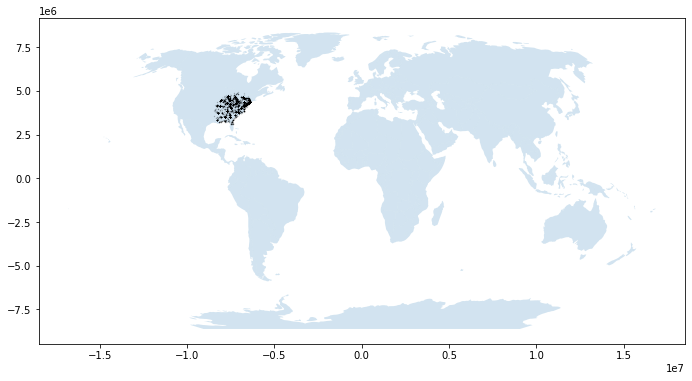

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

gdf_ne.to_crs({'proj': 'robin'}).plot(ax=ax, alpha=0.2)
gdf.to_crs({'proj': 'robin'}).plot(ax=ax, c='k', markersize=0.1, alpha=0.1);

# `$geoNear` Aggregation

> Outputs documents in order of nearest to farthest from a specified point. ([Source](https://docs.mongodb.com/manual/reference/operator/aggregation/geoNear/#pipe._S_geoNear))

```js
db.gdelt.aggregate([
   {
     $geoNear: {
        near: { type: "Point", coordinates: [-84.6514, 37.669] },
        distanceField: "dist.calculated",
        maxDistance: 1000,
        //query: { category: "Parks" },
        includeLocs: "dist.location",
        spherical: true
     }
   }
])
```

In [13]:
query = [
   {
     "$geoNear": {
        "near": { "type": "Point", "coordinates": [-84.6514, 37.669] },
        "distanceField": "dist.calculated",
        "maxDistance": 1000000,
        #"query": { "category": "Parks" },
        "includeLocs": "dist.location",
        "spherical": True
     }
   }
]

with pymongo.MongoClient(MONGODB_URI) as client:
    db = client["sgds"]
    df = pd.DataFrame(db.gdelt_20200101.aggregate(query))
    df['distance'] = df['dist'].apply(lambda d: d['calculated'])
    df['geometry'] = df['geometry'].apply(shapely.geometry.shape)
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='epsg:4326')

query.append({ "$limit": 2 })
    
with pymongo.MongoClient(MONGODB_URI) as client:
    db = client["sgds"]
    for document in db.gdelt_20200101.aggregate(query):
        pprint(document)

{'_id': ObjectId('5f6604806a2b7da01178b1b0'),
 'date': datetime.datetime(2020, 1, 1, 0, 0),
 'dist': {'calculated': 7.136220245898963e-10,
          'location': {'coordinates': [-84.6514, 37.669000000000004],
                       'type': 'Point'}},
 'event_base_code': 42,
 'event_code': 42,
 'event_date': datetime.datetime(2019, 1, 1, 0, 0),
 'event_id': 896047517,
 'event_root_code': 4,
 'geometry': {'coordinates': [-84.6514, 37.669000000000004], 'type': 'Point'},
 'lat': 37.669000000000004,
 'lon': -84.6514,
 'source_url': 'https://www.whas11.com/article/news/local/man-convicted-of-2014-murder-says-he-should-have-been-pardoned-by-bevin/417-57acce42-8ad3-4274-9a7f-b556334c8e64'}
{'_id': ObjectId('5f6604806a2b7da01178b40c'),
 'date': datetime.datetime(2020, 1, 1, 0, 0),
 'dist': {'calculated': 7.136220245898963e-10,
          'location': {'coordinates': [-84.6514, 37.669000000000004],
                       'type': 'Point'}},
 'event_base_code': 23,
 'event_code': 23,
 'event_date': 

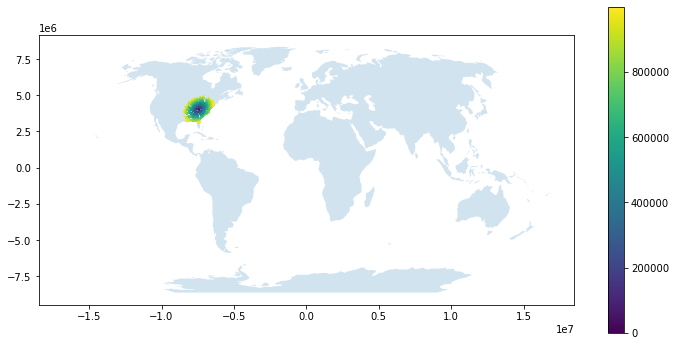

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

gdf_ne.to_crs({'proj': 'robin'}).plot(ax=ax, alpha=0.2)
gdf.to_crs({'proj': 'robin'}).plot(
    ax=ax, column='distance', markersize=0.2, legend=True);

# `$geoIntersects` and `$geoWithin` Query

> Selects documents whose geospatial data intersects with a specified GeoJSON object; i.e. where the intersection of the data and the specified object is non-empty. ([Source geoIntersects](https://docs.mongodb.com/manual/reference/operator/query/geoIntersects/#op._S_geoIntersects))

> Selects documents with geospatial data that exists entirely within a specified shape. ([Source geoWithin](https://docs.mongodb.com/manual/reference/operator/query/geoWithin/))

- [\$geometry](https://docs.mongodb.com/manual/reference/operator/query/geometry/#op._S_geometry) - 2dsphere index
- [\$box](https://docs.mongodb.com/manual/reference/operator/query/box/#op._S_box) - 2d index
- [\$polygon](https://docs.mongodb.com/manual/reference/operator/query/polygon/#op._S_polygon) - 2d index
- [\$center](https://docs.mongodb.com/manual/reference/operator/query/center/#op._S_center) - 2d index
- [\$centerSphere](https://docs.mongodb.com/manual/reference/operator/query/centerSphere/#op._S_centerSphere) - 2dsphere index

In [15]:
EXTENT = [-126.6,23.1,-64.4,49.3]

geom = shapely.geometry.box(*EXTENT)
geometry = shapely.geometry.mapping(geom)
geometry

{'type': 'Polygon',
 'coordinates': (((-64.4, 23.1),
   (-64.4, 49.3),
   (-126.6, 49.3),
   (-126.6, 23.1),
   (-64.4, 23.1)),)}

In [16]:
query = {
    "geometry": {
        "$geoWithin": {
            "$geometry": geometry
        }
    }
}

with pymongo.MongoClient(MONGODB_URI) as client:
    db = client["sgds"]
    for document in db.gdelt_20200101.find(query).limit(2):
        pprint(document)
        
with pymongo.MongoClient(MONGODB_URI) as client:
    db = client["sgds"]
    df = pd.DataFrame(db.gdelt_20200101.find(query))
    df['geometry'] = df['geometry'].apply(shapely.geometry.shape)
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='epsg:4326')

{'_id': ObjectId('5f6604856a2b7da011799231'),
 'date': datetime.datetime(2020, 1, 1, 0, 0),
 'event_base_code': 190,
 'event_code': 190,
 'event_date': datetime.datetime(1920, 1, 1, 0, 0),
 'event_id': 896130902,
 'event_root_code': 19,
 'geometry': {'coordinates': [-123.805, 39.4457], 'type': 'Point'},
 'lat': 39.4457,
 'lon': -123.805,
 'source_url': 'https://www.stripes.com/news/afghanistan-remembering-the-fallen-in-2019-1.613124'}
{'_id': ObjectId('5f6604856a2b7da011799233'),
 'date': datetime.datetime(2020, 1, 1, 0, 0),
 'event_base_code': 190,
 'event_code': 190,
 'event_date': datetime.datetime(1920, 1, 1, 0, 0),
 'event_id': 896130904,
 'event_root_code': 19,
 'geometry': {'coordinates': [-123.805, 39.4457], 'type': 'Point'},
 'lat': 39.4457,
 'lon': -123.805,
 'source_url': 'https://www.stripes.com/news/afghanistan-remembering-the-fallen-in-2019-1.613124'}


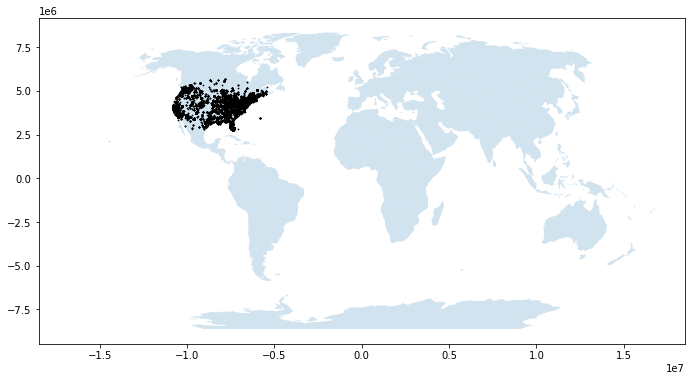

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))

gdf_ne.to_crs({'proj': 'robin'}).plot(ax=ax, alpha=0.2)
gdf.to_crs({'proj': 'robin'}).plot(ax=ax, c='k', markersize=0.5);

In [18]:
geom = gdf_ne[gdf_ne['ISO_A2'] == 'US'].iloc[0]['geometry']
geometry = shapely.geometry.mapping(geom)

query = {
    "geometry": {
        "$geoWithin": {
            "$geometry": geometry
        }
    }
}

with pymongo.MongoClient(MONGODB_URI) as client:
    db = client["sgds"]
    for document in db.gdelt_20200101.find(query).limit(2):
        pprint(document)
        
with pymongo.MongoClient(MONGODB_URI) as client:
    db = client["sgds"]
    df = pd.DataFrame(db.gdelt_20200101.find(query))
    df['geometry'] = df['geometry'].apply(shapely.geometry.shape)
    gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='epsg:4326')

{'_id': ObjectId('5f6604856a2b7da011799231'),
 'date': datetime.datetime(2020, 1, 1, 0, 0),
 'event_base_code': 190,
 'event_code': 190,
 'event_date': datetime.datetime(1920, 1, 1, 0, 0),
 'event_id': 896130902,
 'event_root_code': 19,
 'geometry': {'coordinates': [-123.805, 39.4457], 'type': 'Point'},
 'lat': 39.4457,
 'lon': -123.805,
 'source_url': 'https://www.stripes.com/news/afghanistan-remembering-the-fallen-in-2019-1.613124'}
{'_id': ObjectId('5f6604856a2b7da011799233'),
 'date': datetime.datetime(2020, 1, 1, 0, 0),
 'event_base_code': 190,
 'event_code': 190,
 'event_date': datetime.datetime(1920, 1, 1, 0, 0),
 'event_id': 896130904,
 'event_root_code': 19,
 'geometry': {'coordinates': [-123.805, 39.4457], 'type': 'Point'},
 'lat': 39.4457,
 'lon': -123.805,
 'source_url': 'https://www.stripes.com/news/afghanistan-remembering-the-fallen-in-2019-1.613124'}


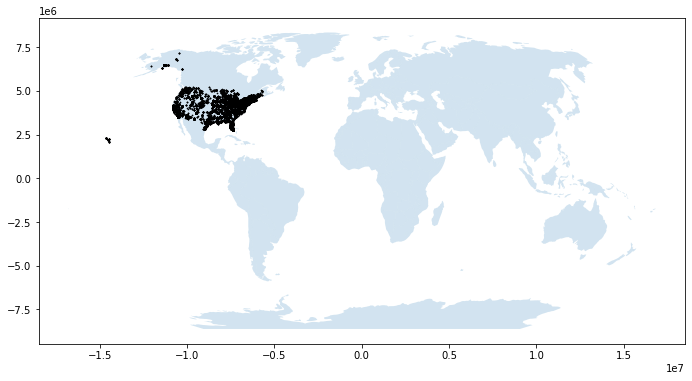

In [19]:
fig, ax = plt.subplots(figsize=(12, 6))

gdf_ne.to_crs({'proj': 'robin'}).plot(ax=ax, alpha=0.2)
gdf.to_crs({'proj': 'robin'}).plot(ax=ax, c='k', markersize=0.5);